## Neural network

In [333]:
import copy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import glob
import os
from sklearn import preprocessing
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

In [15]:
# with open('models/my_df_list_total.pickle', 'rb') as f:
#     df_total_final = pickle.load(f)
    
# with open('models/my_df_feature_extraction_list_total.pickle', 'rb') as f:
#     df_total_final_feature_extraction = pickle.load(f)

In [173]:
# # get feature values for all flows from all packet capture and remove missing values due to inconsistent timestamp
# # if the number of samples (consectutive timestamp) between two missing values is greater than 11, keep it as an individual dataset
# # in the most extreme case, the last sample of the 11 will be used as output for either testing or training 
# # and the previous 10 samples (5s) will be used to as features
# # time aggregation is 500ms

# # all files from both Webex and Webrtc
# files = glob.glob("Retina/shared/*/*/*_500ms_Song_no_log.csv")

# scaler = preprocessing.MinMaxScaler() # for normalization

# # get all of the individual flows from all csv files
# df_total = []
# for file in files:   
#     df_input = pd.read_csv(file)
    
#     # made a copy just in case, only keep those with receiver being ourselves, drop useless columns
#     df_inter = copy.deepcopy(df_input)
#     df_inter = df_inter.loc[~df_inter['ip_src'].str.startswith('192')]
#     drop_col = [
#         'software', 
#         'label', 
#         'pcap', 
#         'ssrc', 
#         'rtp_seq_num_packet_loss', 
#         'ip_src', 
#         'ip_dst', 
#         'prt_src', 
#         'prt_dst', 
#         'rtp_csrc_csrc_agg',
#         'p_type'
#     ]
#     for col in df_inter.columns:
#         if col in drop_col or col.startswith('rtp_interarrival'): # maybe also for 'rtp_inter'
#             df_inter.drop(col, axis=1, inplace=True)
    
#     # break down into individual flows
#     flow_list = df_inter['flow'].drop_duplicates().tolist()
#     for flow in flow_list:
#         df_check = df_inter[df_inter['flow'] == flow].copy()
#         if df_check.shape[0] > 11: 
#             df_total.append(df_check)

# # for each individual flow, deal with potential missing values            
# df_total_final = []
# for df_per_flow in df_total:
#     df_temp = copy.deepcopy(df_per_flow)
#     df_temp.reset_index(inplace=True)
#     df_temp['lossOrNot'] = [1 if x>0 else 0 for x in df_temp['num_packet_loss']] # we only need the presence condition of packet loss
#     df_temp.drop(['num_packet_loss', 'index', 'flow'], axis=1, inplace=True)
    
#     # normalization
#     for col in df_temp.columns:
#         if col not in ['timestamp', 'lossOrNot']:
#             df_temp[col] = scaler.fit_transform(df_temp[col].values.reshape(-1,1))
    
#     # get the beginning and ending timestamp to check whether there's missing value or not and build the complete df
#     start_time = pd.to_datetime(df_temp['timestamp'].min())
#     stop_time = pd.to_datetime(df_temp['timestamp'].max())
#     timestamp_ser = pd.date_range(start_time, stop_time, freq="500L")
#     correct_len = len(timestamp_ser)
    
#     # if there is no missing values, just add it to the list
#     if df_temp.shape[0] == correct_len:
#         df_full = copy.deepcopy(df_temp)
#         df_total_final.append(df_full)
    
#     # if there is at least one missing value, break down the whole flow and add those with length >= 11 to the list
#     else:
#         # merge df without missing value and df with missing value
#         df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
#         df_full = pd.DataFrame({'timestamp': timestamp_ser})
#         df_full['timestamp'] = df_full['timestamp']
#         df_full = df_full.merge(df_temp, on='timestamp', how='left')
        
#         # missing values will result in 'nan' for all columns and find these row(index)
#         nan_index_list = [0]
#         nan_index_list.extend(df_full[np.isnan(df_full['interarrival_std'])].index.tolist())
#         nan_index_list.append(df_full.index[-1])
        
#         # check the distance between each missing value (index) and keep those >= 11 in between 
#         for i in range(1, len(nan_index_list)):
#             if nan_index_list[i] - nan_index_list[i-1] - 1 >= 11:
#                 start_idx = 0 if nan_index_list[i-1]==0 else nan_index_list[i-1]+1
#                 stop_idx = df_full.index[-1]+1 if nan_index_list[i]==df_full.index[-1] else nan_index_list[i]
#                 df_separate = df_full.iloc[start_idx:stop_idx, :].copy()
#                 df_separate.reset_index(inplace=True)
#                 df_separate.drop(['index'], axis=1, inplace=True)
#                 df_total_final.append(df_separate)

In [424]:
# remove those with correlation >= 0.9

complete_list = ['timestamp', 'lossOrNot']
selected_features_list_removing_correlation = [
    'interarrival_std',
#     'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
#     'interarrival_max_value_count_percent',
    'len_udp_moment4',
#     'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]
complete_list.extend(selected_features_list_removing_correlation)

full_features_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1,11):
        col_title = f'{feature}_minus_{500*i}ms'
        full_features_list.append(col_title)

In [174]:
# # based on the features selected before, create the columns based on previous values (in past 5s, 10 samples)
# # get rid of the first 10 lines 

# group_id = 1
# df_total_final_feature_extraction = []
# for df in df_total_final:
#     df_temp = copy.deepcopy(df)
#     df_temp = df_temp[complete_list]
#     df_temp['group_id'] = group_id
#     group_id += 1
#     for feature in selected_features_list_removing_correlation:
#         for i in range(1,11):
#             col_title = f'{feature}_minus_{500*i}ms'
#             df_temp[col_title] = df_temp[feature].shift(periods=i, fill_value=-1)
#     df_temp.drop(selected_features_list_removing_correlation, axis=1, inplace=True)
#     df_temp = df_temp.iloc[10:]
#     df_temp.reset_index(inplace=True)
#     df_temp.drop(['index'], axis=1, inplace=True)
    
#     df_total_final_feature_extraction.append(df_temp)

In [175]:
# df_complete_with_features_final = pd.concat(df_total_final_feature_extraction)
# df_complete_with_features_final.reset_index(inplace=True)
# df_complete_with_features_final.drop(['index'], axis=1, inplace=True)

In [184]:
# with open(f'models/df_final_label_feature.csv', "w") as file:
#     df_complete_with_features_final.to_csv(file, index=False)
df_complete_with_features_final = pd.read_csv('models/df_final_label_feature.csv')

In [190]:
df_complete_with_features_final.shape

(2028660, 113)

In [191]:
df_complete_with_features_final

,timestamp,lossOrNot,group_id,interarrival_std_minus_500ms,interarrival_std_minus_1000ms,interarrival_std_minus_1500ms,interarrival_std_minus_2000ms,interarrival_std_minus_2500ms,interarrival_std_minus_3000ms,interarrival_std_minus_3500ms,...,inter_time_sequence_std_minus_500ms,inter_time_sequence_std_minus_1000ms,inter_time_sequence_std_minus_1500ms,inter_time_sequence_std_minus_2000ms,inter_time_sequence_std_minus_2500ms,inter_time_sequence_std_minus_3000ms,inter_time_sequence_std_minus_3500ms,inter_time_sequence_std_minus_4000ms,inter_time_sequence_std_minus_4500ms,inter_time_sequence_std_minus_5000ms
0,2020-12-14 13:34:44.500000,0.0,1,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,0.584144,...,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312,0.000000
1,2020-12-14 13:34:45,0.0,1,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,...,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312
2,2020-12-14 13:34:45.500000,0.0,1,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,...,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376
3,2020-12-14 13:34:46,0.0,1,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,...,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850
4,2020-12-14 13:34:46.500000,0.0,1,0.113890,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,...,0.210085,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028655,2020-05-13 14:59:09.000,0.0,6998,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,0.069150,...,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018,0.934599
2028656,2020-05-13 14:59:09.500,0.0,6998,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,...,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018
2028657,2020-05-13 14:59:10.000,0.0,6998,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,...,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018
2028658,2020-05-13 14:59:10.500,0.0,6998,0.133611,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,...,0.223662,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054


In [192]:
df_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] > 0]
df_no_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] < 1]

df_loss_shuffled = df_loss.sample(frac=1).reset_index()
df_loss_shuffled.drop(['index'], axis=1, inplace=True)
df_no_loss_shuffled = df_no_loss.sample(frac=1).reset_index()
df_no_loss_shuffled.drop(['index'], axis=1, inplace=True)

## original way

In [276]:
# 1st try with original

df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_no_loss_shuffled.shape[0] * 0.7)]])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_no_loss_shuffled.shape[0] * 0.7)+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

In [277]:
x_train = df_train_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

In [330]:
my_model = keras.Sequential([
    keras.layers.Input(shape=(110,)), 
    keras.layers.Dense(110, activation='relu'),
    keras.layers.Dense(55, activation='relu'),
    keras.layers.Dense(2, activation='softmax') 
])

In [331]:
my_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=keras.losses.BinaryCrossentropy(),
#     metrics=[keras.metrics.AUC()]
    metrics=['accuracy']
)

In [ ]:
my_model.fit(x_train, y_train, batch_size=32, epochs=10)

In [311]:
predictions = my_model.predict(x_test)

In [ ]:
predictions
prediction_label = [0 if x<0.5 else 1 for x in predictions]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test['lossOrNot'].tolist(), prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## undersampling

In [198]:
# 2nd try with undersampling

df_train_under_sampling = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)]])
df_train_shuffled = df_train_under_sampling.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test_under_sampling = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1]])
df_test_shuffled = df_test_under_sampling.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

In [248]:
x_train = df_train_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

In [249]:
my_model_undersampling = keras.Sequential([
    keras.layers.Input(shape=(110,)), 
    keras.layers.Dense(220, activation='relu'),
    keras.layers.Dense(110, activation='relu'),
    keras.layers.Dense(55, activation='relu'),
    keras.layers.Dense(2, activation='softmax') 
])

In [250]:
my_model_undersampling.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [252]:
my_model_undersampling.fit(x_train, y_train, epochs=20)

Epoch 1/20
1234/1234 [==============================] - 16s 13ms/step - loss: 0.5429 - accuracy: 0.7241
Epoch 2/20
1234/1234 [==============================] - 16s 13ms/step - loss: 0.5421 - accuracy: 0.7259
Epoch 3/20
1234/1234 [==============================] - 14s 11ms/step - loss: 0.5397 - accuracy: 0.7279
Epoch 4/20
1234/1234 [==============================] - 17s 13ms/step - loss: 0.5336 - accuracy: 0.7297
Epoch 5/20
1234/1234 [==============================] - 17s 14ms/step - loss: 0.5339 - accuracy: 0.7301
Epoch 6/20
1234/1234 [==============================] - 13s 10ms/step - loss: 0.5311 - accuracy: 0.7333
Epoch 7/20
1234/1234 [==============================] - 75s 61ms/step - loss: 0.5291 - accuracy: 0.7332
Epoch 8/20
1234/1234 [==============================] - 67s 55ms/step - loss: 0.5270 - accuracy: 0.7359
Epoch 9/20
1234/1234 [==============================] - 123s 99ms/step - loss: 0.5263 - accuracy: 0.7345
Epoch 10/20
1234/1234 [==============================] - 98s 80

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.76      0.86   1980707
           1       0.01      0.70      0.02      8461

    accuracy                           0.76   1989168
   macro avg       0.51      0.73      0.44   1989168
weighted avg       0.99      0.76      0.86   1989168



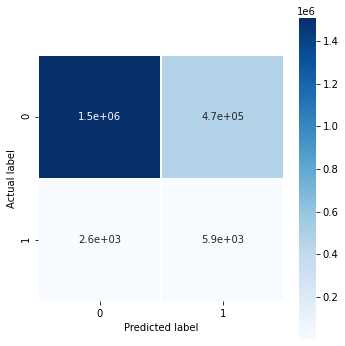

In [253]:
predictions = my_model_undersampling.predict(x_test)
prediction_label = [np.argmax(x) for x in predictions]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test['lossOrNot'].tolist(), prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [425]:
shrink_feature_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1,3):
        col_title = f'{feature}_minus_{500*i}ms'
        shrink_feature_list.append(col_title)

In [426]:
x_train_new = df_train_shuffled[shrink_feature_list]
x_test_new = df_test_shuffled[shrink_feature_list]
y_train_new = df_train_shuffled[['lossOrNot']]
y_train_new = y_train_new.astype(int)
y_test_new = df_test_shuffled[['lossOrNot']]
y_test_new = y_test_new.astype(int)

In [427]:
x_train_new.shape

(217192, 16)

In [274]:
my_model_undersampling_less_features = keras.Sequential([
    keras.layers.Input(shape=(66,)), 
    keras.layers.Dense(132, activation='relu'),
    keras.layers.Dense(132, activation='relu'),
    keras.layers.Dense(66, activation='relu'),
#     keras.layers.Dense(33, activation='relu'),
#     keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(2, activation='softmax') 
])

my_model_undersampling_less_features.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
my_model_undersampling_less_features.fit(x_train_new, y_train_new, epochs=20)

## Combination of under and over sampling

In [334]:
df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7 * 10)]])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7 * 10)+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

In [335]:
x_train = df_train_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

In [428]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train_new, y_train_new)

In [432]:
x_train_smote.shape

(394896, 16)

In [433]:
my_model_combination = keras.Sequential([
    keras.layers.Input(shape=(16,)), 
    keras.layers.Dense(32, activation='relu'),
#     keras.layers.Dropout(0.1),
    keras.layers.Dense(16, activation='relu'),
#     keras.layers.Dropout(0.1),
#     keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(2, activation='softmax') 
])

In [434]:
my_model_combination.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [435]:
my_model_combination.fit(x_train_smote, y_train_smote, epochs=10)

Epoch 1/10
12341/12341 [==============================] - 250s 20ms/step - loss: 0.6062 - accuracy: 0.6655
Epoch 2/10
11415/12341 [==========================>...] - ETA: 23s - loss: 0.5821 - accuracy: 0.6881

KeyboardInterrupt: 

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.71      0.83   1803003
           1       0.01      0.77      0.02      8461

    accuracy                           0.71   1811464
   macro avg       0.51      0.74      0.43   1811464
weighted avg       0.99      0.71      0.82   1811464



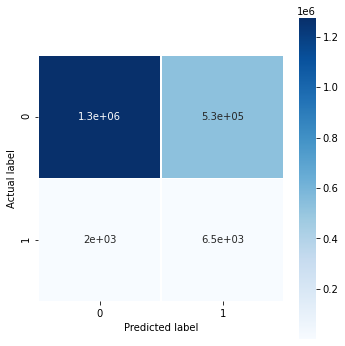

In [357]:
predictions = my_model_combination.predict(x_test_new)
prediction_label = [np.argmax(x) for x in predictions]
print("Prediction Report\n", classification_report(y_test_new, prediction_label))
cm = confusion_matrix(y_test['lossOrNot'].tolist(), prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [360]:
# my_model_combination.save('models/my_first_nn_model_combination')
# my_model_combination_load = keras.models.load_model('saved_model/my_first_nn_model_combination')

INFO:tensorflow:Assets written to: models/my_first_nn_model_combination/assets


In [391]:
df_test = df_complete_with_features_final[df_complete_with_features_final['group_id'] == 4]
predictions_test = my_model_combination.predict(df_test[full_features_list])
prediction_test_label = [np.argmax(x) for x in predictions]

In [392]:
prediction_test_prob = [x[1] for x in predictions]

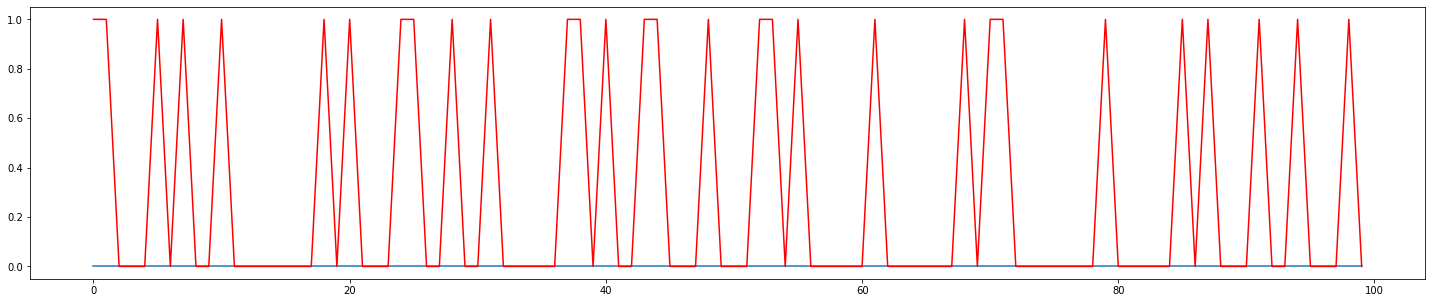

In [395]:
plt.figure(figsize=(25,5))
plt.plot(df_test.iloc[0:100]['lossOrNot'].tolist())
plt.plot(prediction_test_label[0:100], color='r')
plt.show()